# Importando bibliotecas importantes

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import keras
import numpy as np

In [2]:
%matplotlib notebook 
import matplotlib.pyplot as plt

### Bibliotecas pessoais

In [3]:
from dataHandler import dataHandler

# Carregando dados

In [32]:
data = dataHandler()
data.loadData()

### Codificando labels via One Hot Encoding

In [33]:
data.oneHotEncode()

In [34]:
print("- Foram detectadas %d classes diferentes" % data.getClassCount())

- Foram detectadas 26 classes diferentes


### Obtendo dados
Os dados de treino e teste são divididos durante o carregamento

In [35]:
train_features, test_features = data.getFeatures()
train_labels, test_labels = data.getLabels()

### Visualizando dados

In [36]:
print(train_labels[0])
print(train_labels[1])

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [37]:
print(train_features[0][1000:1500])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 3, 20, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 2, 1, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 23, 2, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 10, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [38]:
print("- Tamanho do conjunto de treino: %d" % len(train_features))
print("- Tamanho do conjunto de teste: %d" % len(test_features))

- Tamanho do conjunto de treino: 3380
- Tamanho do conjunto de teste: 1040


# Criando rede neural

In [39]:
inputShape = len(train_features[0])
numClasses = data.getClassCount()

print("- Tamanho linear dos dados de entrada: %d" % inputShape)

- Tamanho linear dos dados de entrada: 4096


In [40]:
model = keras.Sequential()
model.add(keras.layers.Dense(2400, input_dim=inputShape, activation='selu'))
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.normalization.BatchNormalization())

model.add(keras.layers.Dense(1800, input_dim=inputShape, activation='selu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(800, input_dim=inputShape, activation='selu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(numClasses, activation="softmax"))

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2400)              9832800   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2400)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2400)              9600      
_________________________________________________________________
dense_5 (Dense)              (None, 1800)              4321800   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1800)              7200      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1800)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 800)              

## Compilando modelo

In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando modelo

In [51]:
history = model.fit(train_features, train_labels, epochs=100, batch_size=128, validation_data=(test_features, test_labels))

Epoch 1/100
27/27 [==============================] - 11s 412ms/step - loss: 0.7091 - accuracy: 0.7556 - val_loss: 4.0442 - val_accuracy: 0.4654
Epoch 2/100
27/27 [==============================] - 1s 24ms/step - loss: 0.6834 - accuracy: 0.7692 - val_loss: 4.1617 - val_accuracy: 0.4760
Epoch 3/100
27/27 [==============================] - 1s 24ms/step - loss: 0.6950 - accuracy: 0.7624 - val_loss: 3.9592 - val_accuracy: 0.4760
Epoch 4/100
27/27 [==============================] - 1s 24ms/step - loss: 0.6691 - accuracy: 0.7725 - val_loss: 4.1172 - val_accuracy: 0.4596
Epoch 5/100
27/27 [==============================] - 1s 26ms/step - loss: 0.6932 - accuracy: 0.7692 - val_loss: 4.1427 - val_accuracy: 0.4625
Epoch 6/100
27/27 [==============================] - 1s 25ms/step - loss: 0.7116 - accuracy: 0.7657 - val_loss: 3.9170 - val_accuracy: 0.4683
Epoch 7/100
27/27 [==============================] - 1s 24ms/step - loss: 0.6827 - accuracy: 0.7689 - val_loss: 4.2276 - val_accuracy: 0.4731
Epoc

27/27 [==============================] - 1s 23ms/step - loss: 0.5022 - accuracy: 0.8317 - val_loss: 4.0552 - val_accuracy: 0.4923
Epoch 59/100
27/27 [==============================] - 1s 23ms/step - loss: 0.5220 - accuracy: 0.8163 - val_loss: 4.2393 - val_accuracy: 0.4721
Epoch 60/100
27/27 [==============================] - 1s 23ms/step - loss: 0.5226 - accuracy: 0.8207 - val_loss: 4.5202 - val_accuracy: 0.4875
Epoch 61/100
27/27 [==============================] - 1s 23ms/step - loss: 0.5026 - accuracy: 0.8249 - val_loss: 4.4100 - val_accuracy: 0.4885
Epoch 62/100
27/27 [==============================] - 1s 24ms/step - loss: 0.4984 - accuracy: 0.8281 - val_loss: 4.2719 - val_accuracy: 0.4798
Epoch 63/100
27/27 [==============================] - 1s 24ms/step - loss: 0.5289 - accuracy: 0.8157 - val_loss: 4.5484 - val_accuracy: 0.4750
Epoch 64/100
27/27 [==============================] - 1s 24ms/step - loss: 0.4948 - accuracy: 0.8314 - val_loss: 4.4264 - val_accuracy: 0.4712
Epoch 65/100

<IPython.core.display.Javascript object>


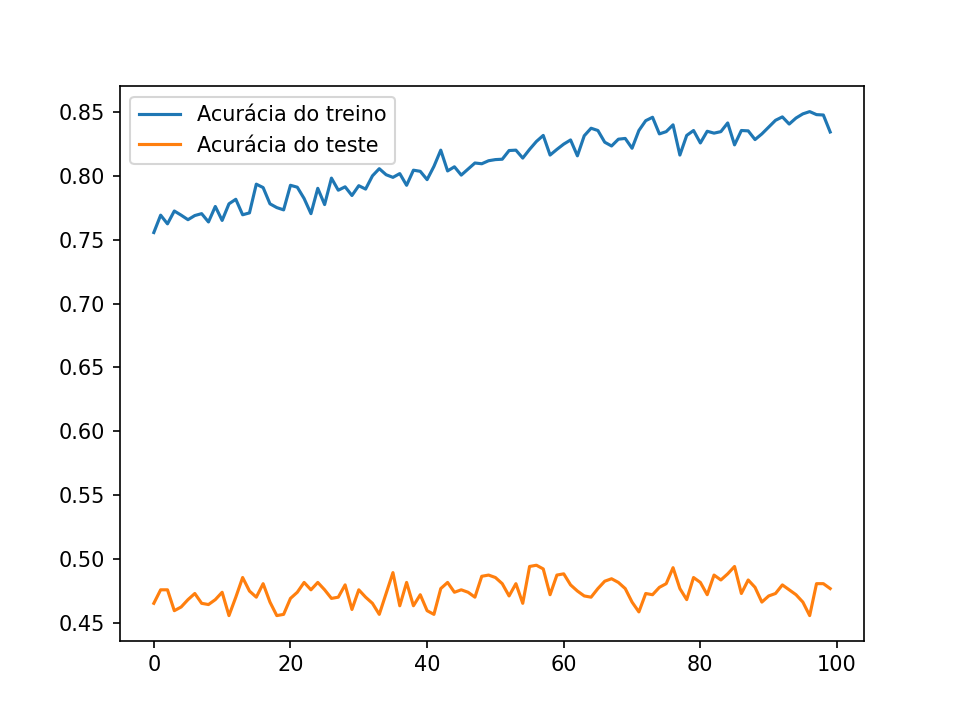

In [57]:
plt.figure()
plt.plot(history.history['accuracy'], label="Acurácia do treino")
plt.plot(history.history['val_accuracy'], label = "Acurácia do teste")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


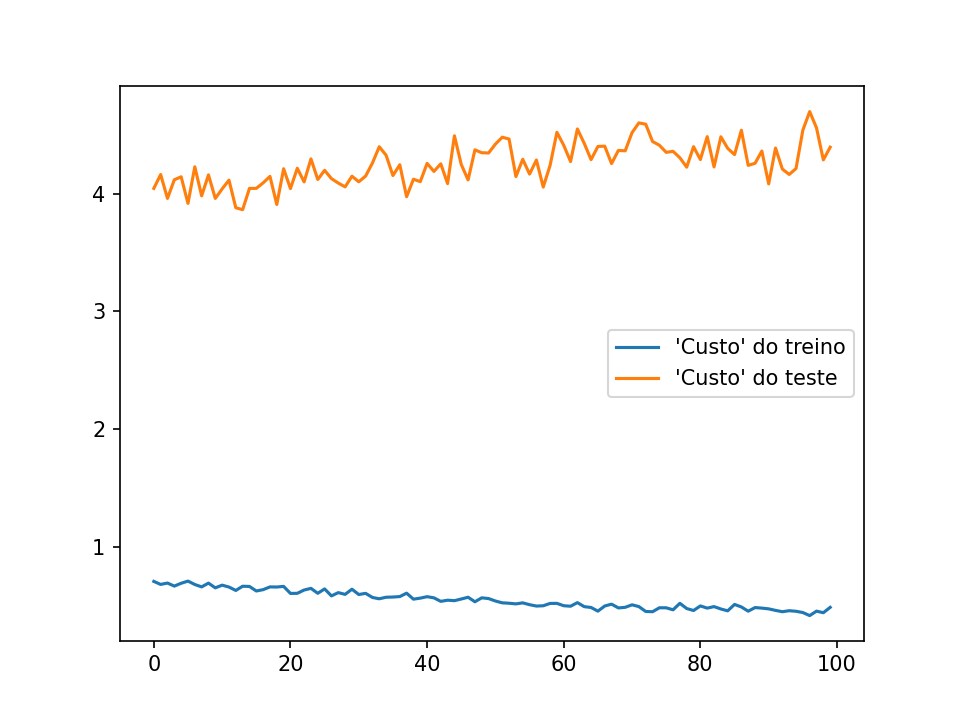

In [58]:
plt.figure()
plt.plot(history.history['loss'], label = "'Custo' do treino")
plt.plot(history.history['val_loss'], label= "'Custo' do teste")
plt.legend()
plt.show()

# Avaliando modelo

In [107]:
_, accuracy = model.evaluate(test_features, test_labels)
print("Acurácia do modelo nos dados de teste: %.2f%%" % (accuracy*100.0))

27/27 [==============================] - 0s 9ms/step - loss: 7.1882 - accuracy: 0.4738
Acurácia do modelo nos dados de teste: 47.38%


# Testando modelo

In [18]:
import cv2

# Função para carregar imagem
def loadImage(fileName, printImg = False):
    # Carrega a imagem e aplica um threshold para ficar igual
    # as imagens do treino
    img = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV) 

    # Ajusta o tamanho da imagem
    img = cv2.resize(img, (64,64))
    
    if printImg:
        plt.figure()
        plt.imshow(img, cmap='gray')
    
    return list(img.flatten().tolist())


def getChar(x):
    label = model.predict([x], batch_size=1)
    
    char = data.oneHotDecode(label)
    
    return char

In [52]:
x = loadImage("testes/letraa.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi q


In [53]:
x = loadImage("testes/letraa2.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi a


In [54]:
x = loadImage("testes/letraAu.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi a


In [55]:
x = loadImage("testes/cidilha.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi q


In [56]:
x = loadImage("testes/cidilhau.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi z
